# Heat transfer

TODO:
- turn into 2D

In [1]:
from dolfinx import fem
import ufl
from mpi4py import MPI
import numpy as np

def error_L2(u_computed, u_exact, degree_raise=3):
    # Create higher order function space
    degree = u_computed.function_space.ufl_element().degree()
    family = u_computed.function_space.ufl_element().family()
    mesh = u_computed.function_space.mesh
    W = fem.FunctionSpace(mesh, (family, degree + degree_raise))
    # Interpolate approximate solution
    u_W = fem.Function(W)
    u_W.interpolate(u_computed)

    # Interpolate exact solution, special handling if exact solution
    # is a ufl expression or a python lambda function
    u_ex_W = fem.Function(W)
    if isinstance(u_exact, ufl.core.expr.Expr):
        u_expr = fem.Expression(u_exact, W.element.interpolation_points)
        u_ex_W.interpolate(u_expr)
    else:
        u_ex_W.interpolate(u_exact)

    # Compute the error in the higher order function space
    e_W = fem.Function(W)
    e_W.x.array[:] = u_W.x.array - u_ex_W.x.array

    # Integrate the error
    error = fem.form(ufl.inner(e_W, e_W) * ufl.dx)
    error_local = fem.assemble_scalar(error)
    error_global = mesh.comm.allreduce(error_local, op=MPI.SUM)
    return np.sqrt(error_global)

In [29]:
import festim as F

thermal_conductivity = lambda T: 3 * T + 2
exact_solution = lambda x: 2 * x[0] ** 2 + 1
mms_source = lambda x: -(72 * x[0] ** 2 + 20)  # TODO would be nice to automate

my_problem = F.HeatTransferProblem()

my_problem.mesh = F.Mesh1D(vertices=np.linspace(0, 1, 2000))
left = F.SurfaceSubdomain1D(id=1, x=0)
right = F.SurfaceSubdomain1D(id=2, x=1)
mat = F.Material(D_0=None, E_D=None)
mat.thermal_conductivity = thermal_conductivity

my_problem.subdomains = [
    left,
    right,
    F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat),
]
my_problem.boundary_conditions = [
    F.FixedTemperatureBC(subdomain=left, value=exact_solution),
    F.FixedTemperatureBC(subdomain=right, value=exact_solution),
]

my_problem.sources = [
    F.HeatSource(value=mms_source, volume=my_problem.volume_subdomains[0])
]

my_problem.settings = F.Settings(
    atol=1e-10,
    rtol=1e-10,
    transient=False,
)

my_problem.initialise()
my_problem.run()

computed_solution = my_problem.u
L2_error = error_L2(computed_solution, exact_solution)
print(f"L2 error: {L2_error:.2e}")

L2 error: 6.15e-08


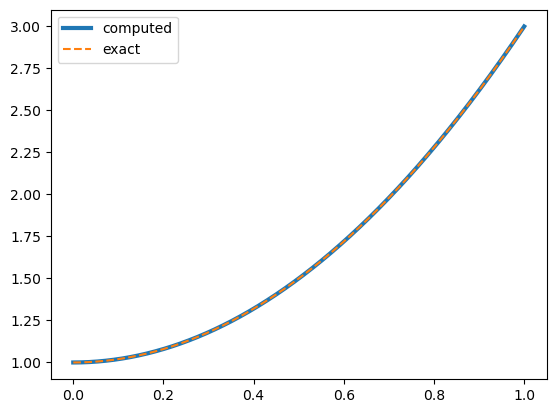

In [31]:
T = my_problem.u
x = T.function_space.tabulate_dof_coordinates()
x_order = np.argsort(x[:,0])

import matplotlib.pyplot as plt

plt.plot(x[x_order, 0], T.x.array[x_order], label='computed', linewidth=3)
plt.plot(x[x_order, 0], exact_solution([x[x_order, 0]]), label="exact", linestyle='--')
plt.legend()